In [2]:
from datasets import load_dataset

ds = load_dataset("IsmaelMousa/books")

In [3]:
data = ds['train']['EN'][0][27:]

In [4]:
def strip_newlines(data):
    return data.replace('\n', '')

def make_splits(data, n_lines = 2):
    result = []
    sentences = data.split('.')
    for i in range(0, len(sentences), n_lines):
        chunk = '.'.join(sentences[i:i+n_lines])
        if chunk:  # Only add non-empty chunks
            result.append(chunk + '.')
    return result

def add_newlines(text, k = 40):
    result = []
    current_line = ""

    words = text.split()

    # print(text)
    
    for word in words:
        # Check if adding this word would exceed k characters
        if len(current_line) + len(word) + (1 if current_line else 0) >= k:
            # Add current line to result and start new line
            if current_line:
                result.append(current_line)
                current_line = word
            else:
                # Word itself is longer than k, add it anyway
                result.append(word)
        else:
            # Add word to current line
            if current_line:
                current_line += " " + word
            else:
                current_line = word
        
    # Add the last line if it exists
    if current_line:
        result.append(current_line)

    indv_lines = [line + '\n' for line in result[:-1]] + [result[-1]]

    
    return '\n'.join(result), indv_lines

In [5]:
data = strip_newlines(data)
data_split = make_splits(data, n_lines=4)
for line in data_split:
    text, indv_lines = add_newlines(line, k=150)
    print(line)
    print(repr(text))
    print(indv_lines)
    print('-'*100)

    break

I was born in the year 1632, in the city of York, of a good family,though not of that country, my father being a foreigner of Bremen, whosettled first at Hull. He got a good estate by merchandise, and leavingoff his trade, lived afterwards at York, from whence he had married mymother, whose relations were named Robinson, a very good family in thatcountry, and from whom I was called Robinson Kreutznaer; but, by theusual corruption of words in England, we are now called nay we callourselves and write our name Crusoe; and so my companions always calledme.I had two elder brothers, one of whom was lieutenant-colonel to anEnglish regiment of foot in Flanders, formerly commanded by the famousColonel Lockhart, and was killed at the battle near Dunkirk against theSpaniards. What became of my second brother I never knew, any more thanmy father or mother knew what became of me.
'I was born in the year 1632, in the city of York, of a good family,though not of that country, my father being a foreig

In [6]:
text

'I was born in the year 1632, in the city of York, of a good family,though not of that country, my father being a foreigner of Bremen, whosettled\nfirst at Hull. He got a good estate by merchandise, and leavingoff his trade, lived afterwards at York, from whence he had married mymother, whose\nrelations were named Robinson, a very good family in thatcountry, and from whom I was called Robinson Kreutznaer; but, by theusual corruption of\nwords in England, we are now called nay we callourselves and write our name Crusoe; and so my companions always calledme.I had two elder brothers,\none of whom was lieutenant-colonel to anEnglish regiment of foot in Flanders, formerly commanded by the famousColonel Lockhart, and was killed at the\nbattle near Dunkirk against theSpaniards. What became of my second brother I never knew, any more thanmy father or mother knew what became of me.'

In [7]:
(indv_lines)

['I was born in the year 1632, in the city of York, of a good family,though not of that country, my father being a foreigner of Bremen, whosettled\n',
 'first at Hull. He got a good estate by merchandise, and leavingoff his trade, lived afterwards at York, from whence he had married mymother, whose\n',
 'relations were named Robinson, a very good family in thatcountry, and from whom I was called Robinson Kreutznaer; but, by theusual corruption of\n',
 'words in England, we are now called nay we callourselves and write our name Crusoe; and so my companions always calledme.I had two elder brothers,\n',
 'one of whom was lieutenant-colonel to anEnglish regiment of foot in Flanders, formerly commanded by the famousColonel Lockhart, and was killed at the\n',
 'battle near Dunkirk against theSpaniards. What became of my second brother I never knew, any more thanmy father or mother knew what became of me.']

In [8]:
from collections import defaultdict

In [9]:
def setup_hooks(model):
    """Setup residual capture hooks"""
    # -------- Residual capture logic --------
    residuals = defaultdict(dict)  # residuals[layer]["pre" or "post"] = tensor

    def make_hook(layer_idx, mode="both"):
        def hook_pre(module, inputs):
            if mode in ("pre", "both"):
                residuals[layer_idx]["pre"] = inputs[0].clone()

        def hook_post(module, inputs, output):
            if mode in ("post", "both"):
                if isinstance(output, tuple):
                    hidden_states = output[0]
                else:
                    hidden_states = output
                residuals[layer_idx]["post"] = hidden_states.clone()

        return hook_pre, hook_post

    # Register hooks
    mode = "both"  # "pre", "post", or "both"
    for i, block in enumerate(model.model.layers):
        hook_pre, hook_post = make_hook(i, mode=mode)
        block.register_forward_pre_hook(hook_pre)
        block.register_forward_hook(hook_post)
    
    return residuals

In [10]:
import dotenv
import os
from transformers import AutoTokenizer, AutoModelForCausalLM

In [11]:
def load_model_and_tokenizer(model_name):
    """Load tokenizer and model"""
    print(f"Loading model: {model_name}")
    path = '/home/kartik/all_keys/.env'
    dotenv.load_dotenv(path)
    hf_token = os.getenv("HF_TOKEN")
    cache = "/mnt/SSD4/kartik/hf_cache"

    HF_TOKEN = os.getenv('HF_TOKEN')

    # Set HuggingFace cache directory globally
    os.environ['HF_HOME'] = cache
    os.environ['HUGGINGFACE_HUB_CACHE'] = cache
    os.environ['TRANSFORMERS_CACHE'] = cache
    os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
    
    tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        trust_remote_code=True,
        device_map="auto",
        cache_dir=cache,
    )
    model.eval()
    print("Model loaded successfully!")
    return model, tokenizer

In [12]:
model, tokenizer = load_model_and_tokenizer('meta-llama/Llama-3.1-8B-Instruct')

Loading model: meta-llama/Llama-3.1-8B-Instruct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded successfully!


In [52]:
import torch

def generate_chat_completion(
    model,
    tokenizer,
    messages,
    max_new_tokens: int = 500,
    temperature: float = 0.7,
    top_p: float = 0.9,
) -> str:


    # === 1) Format messages into a prompt using the tokenizer's chat template ===
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )

    # === 2) Tokenize ===
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)

    # === 3) Generate ===
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # === 4) Extract only the newly generated tokens ===
    input_len = inputs["input_ids"].shape[1]
    new_tokens = outputs[0][input_len:]
    completion = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

    return completion


def create_chat_completion_prompt(tokenizer, user_question: str) -> str:
    """
    Creates a traditional chat completion prompt where the user message contains 
    both the original question and the starter text to complete.
    """
    # Combine the original question with the starter text naturally
    combined_user_message = f"""{user_question}"""
    
    # Create the conversation with only a user message
    messages = [
        {"role": "user", "content": combined_user_message}
    ]
    
    return messages

In [53]:
data = strip_newlines(data)
data_split = make_splits(data, n_lines=4)
for line in data_split:
    text, indv_lines = add_newlines(line, k=150)
    print(line)
    print(repr(text))
    print(indv_lines)
    print('-'*100)

    break

I was born in the year 1632, in the city of York, of a good family,though not of that country, my father being a foreigner of Bremen, whosettled first at Hull. He got a good estate by merchandise, and leavingoff his trade, lived afterwards at York, from whence he had married mymother, whose relations were named Robinson, a very good family in thatcountry, and from whom I was called Robinson Kreutznaer; but, by theusual corruption of words in England, we are now called nay we callourselves and write our name Crusoe; and so my companions always calledme.I had two elder brothers, one of whom was lieutenant-colonel to anEnglish regiment of foot in Flanders, formerly commanded by the famousColonel Lockhart, and was killed at the battle near Dunkirk against theSpaniards. What became of my second brother I never knew, any more thanmy father or mother knew what became of me.
'I was born in the year 1632, in the city of York, of a good family,though not of that country, my father being a foreig

In [46]:
mess = 'give the python code to define a function that takes a list of numbers and returns the sum of the numbers'
mess = create_chat_completion_prompt(tokenizer, mess)

In [47]:
mess

[{'role': 'user',
  'content': 'give the python code to define a function that takes a list of numbers and returns the sum of the numbers'}]

In [48]:
a = generate_chat_completion(model, tokenizer, mess)

In [51]:
print((a))

**Sum of a List of Numbers Function**

Here's a simple Python function that calculates the sum of a list of numbers:

```python
def sum_numbers(numbers):
    """
    Calculate the sum of a list of numbers.

    Args:
        numbers (list): A list of numbers.

    Returns:
        float: The sum of the numbers in the list.

    Raises:
        TypeError: If the input is not a list.
        ValueError: If the list contains non-numeric values.
    """
    if not isinstance(numbers, list):
        raise TypeError("Input must be a list.")
    try:
        return sum(numbers)
    except TypeError:
        raise ValueError("List must only contain numbers.")

# Example usage:
numbers = [1, 2, 3, 4, 5]
result = sum_numbers(numbers)
print(result)  # Output: 15
```

This function uses the built-in `sum()` function in Python, which adds up all the elements in an iterable (like a list). It also includes input validation to ensure that the input is a list and contains only numbers.

However, if you

In [13]:
data = strip_newlines(data)
data_split = make_splits(data, n_lines=4)
for line in data_split:
    text, indv_lines = add_newlines(line, k=150)
    print(line)
    print((text))
    print(indv_lines)
    print('-'*100)

    break

I was born in the year 1632, in the city of York, of a good family,though not of that country, my father being a foreigner of Bremen, whosettled first at Hull. He got a good estate by merchandise, and leavingoff his trade, lived afterwards at York, from whence he had married mymother, whose relations were named Robinson, a very good family in thatcountry, and from whom I was called Robinson Kreutznaer; but, by theusual corruption of words in England, we are now called nay we callourselves and write our name Crusoe; and so my companions always calledme.I had two elder brothers, one of whom was lieutenant-colonel to anEnglish regiment of foot in Flanders, formerly commanded by the famousColonel Lockhart, and was killed at the battle near Dunkirk against theSpaniards. What became of my second brother I never knew, any more thanmy father or mother knew what became of me.
I was born in the year 1632, in the city of York, of a good family,though not of that country, my father being a foreign

In [13]:
import torch

def get_residuals_for_text(inputs, model, tokenizer, residuals, verbose=True):
    """
    Run a single text through the model and record residuals.
    
    Args:
        text (str): input text
        model: HF model (e.g., LlamaForCausalLM)
        tokenizer: matching tokenizer
        residuals (dict): pre-set up hooks dict (layer_idx → {'pre': tensor, 'post': tensor})
    
    Returns:
        torch.Tensor: residual tensor of shape (n_layers, n_tokens, d_model)
    """

    # Clear any previous hooks
    residuals.clear()

    # Tokenize and move to model device
    # inputs = tokenizer(text, return_tensors="pt").to(model.device)
    n_tokens = inputs["input_ids"].size(1)

    # Model dimensions
    num_layers = len(model.model.layers)
    hidden_size = model.config.hidden_size

    # Pre-allocate tensor: (layers, tokens, d_model)
    resid_tensor = torch.zeros(num_layers, n_tokens, hidden_size)

    with torch.no_grad():
        _ = model(**inputs)

    # Collect residuals
    for layer_idx in range(num_layers):
        if layer_idx in residuals and "post" in residuals[layer_idx]:
            post_tensor = residuals[layer_idx]["post"]  # (1, seq_len, d_model)
            resid_tensor[layer_idx, :post_tensor.size(1), :] = post_tensor[0, :, :].cpu()

    if verbose:
        print(f"Captured residuals: shape = {tuple(resid_tensor.shape)}")

    return resid_tensor

In [14]:
data = strip_newlines(data)
data_split = make_splits(data, n_lines=2)
for line in data_split:
    text, indv_lines = add_newlines(line, k=150)
    print(line)
    print(repr(text))
    print(indv_lines)
    print('-'*100)

    break

I was born in the year 1632, in the city of York, of a good family,though not of that country, my father being a foreigner of Bremen, whosettled first at Hull. He got a good estate by merchandise, and leavingoff his trade, lived afterwards at York, from whence he had married mymother, whose relations were named Robinson, a very good family in thatcountry, and from whom I was called Robinson Kreutznaer; but, by theusual corruption of words in England, we are now called nay we callourselves and write our name Crusoe; and so my companions always calledme.
'I was born in the year 1632, in the city of York, of a good family,though not of that country, my father being a foreigner of Bremen, whosettled\nfirst at Hull. He got a good estate by merchandise, and leavingoff his trade, lived afterwards at York, from whence he had married mymother, whose\nrelations were named Robinson, a very good family in thatcountry, and from whom I was called Robinson Kreutznaer; but, by theusual corruption of\n

In [15]:
import numpy as np

all_lens = np.arange(1, 41, 1)
all_lens

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

In [16]:
data = strip_newlines(data)
data_split = make_splits(data, n_lines=5)

In [17]:
# Check for CUDA memory issues and add memory management
import gc
import torch
import numpy as np
from collections import defaultdict
from tqdm import tqdm


k = 40
all_lens = np.arange(1, k+2, 1)
all_resids = {}
for key in all_lens:
    all_resids[key] = torch.empty((model.config.hidden_size, 0))

for i, line in tqdm(enumerate(data_split[:100])):
    cum_len = 0
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    try:
        # Clear CUDA cache and collect garbage to free memory
        torch.cuda.empty_cache()
        gc.collect()
        
        text, indv_lines = add_newlines(line, k=k)
        residuals = setup_hooks(model)
        inputs = tokenizer(text, return_tensors="pt").to(model.device)
        n_tokens = inputs["input_ids"].size(1)
        # print(n_tokens)
        resid = get_residuals_for_text(inputs, model, tokenizer, residuals, verbose=False)
        # print(resid.shape)

        for tok in range(1, n_tokens):
            word = tokenizer.decode(inputs["input_ids"][0][tok])
            cum_len += len(word)
            
            if cum_len <= k+1:
                all_resids[cum_len] = torch.cat((all_resids[cum_len], resid[0, tok, :].unsqueeze(1)), dim=1)

            if word == '\n':
                cum_len = 0

    except torch.cuda.OutOfMemoryError as e:
        print(f"CUDA out of memory error at iteration {i}: {e}")
        print("Skipping this iteration and continuing...")
        torch.cuda.empty_cache()
        gc.collect()
        continue
    except Exception as e:
        print(f"Unexpected error at iteration {i}: {e}")
        print("Terminating process...")
        break

        
torch.save(all_resids, f'data/all_resids_{k}.pt')

0it [00:00, ?it/s]

100it [01:16,  1.31it/s]


In [19]:
for key in all_resids.keys():
    print(key, all_resids[key].shape)

1 torch.Size([4096, 328])
2 torch.Size([4096, 597])
3 torch.Size([4096, 819])
4 torch.Size([4096, 920])
5 torch.Size([4096, 784])
6 torch.Size([4096, 786])
7 torch.Size([4096, 799])
8 torch.Size([4096, 766])
9 torch.Size([4096, 809])
10 torch.Size([4096, 811])
11 torch.Size([4096, 794])
12 torch.Size([4096, 740])
13 torch.Size([4096, 747])
14 torch.Size([4096, 751])
15 torch.Size([4096, 784])
16 torch.Size([4096, 725])
17 torch.Size([4096, 756])
18 torch.Size([4096, 769])
19 torch.Size([4096, 767])
20 torch.Size([4096, 729])
21 torch.Size([4096, 729])
22 torch.Size([4096, 754])
23 torch.Size([4096, 775])
24 torch.Size([4096, 751])
25 torch.Size([4096, 738])
26 torch.Size([4096, 758])
27 torch.Size([4096, 754])
28 torch.Size([4096, 786])
29 torch.Size([4096, 752])
30 torch.Size([4096, 736])
31 torch.Size([4096, 768])
32 torch.Size([4096, 755])
33 torch.Size([4096, 840])
34 torch.Size([4096, 837])
35 torch.Size([4096, 878])
36 torch.Size([4096, 967])
37 torch.Size([4096, 1063])
38 torch.

In [19]:
import torch
import numpy as np

In [20]:
all_res = torch.load(f'data/all_resids_{k}.pt', weights_only=False)
all_res[1].shape

torch.Size([4096, 328])

In [21]:
# do classification code for 40 classes
# X[i] is all_resids[i] and i is the class label

# Prepare data for classification
X = []
y = []
k = 40

for class_label in range(1, k+1):  # classes 1 to 40
    if class_label in all_res:
        # Get residuals for this class (position)
        class_data = all_res[class_label].T  # transpose to get (n_samples, n_features)
        
        # Add to X and create corresponding labels
        X.append(class_data)
        y.extend([class_label] * class_data.shape[0])

# Concatenate all data
X = torch.cat(X, dim=0)
y = torch.tensor(y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Number of classes: {len(torch.unique(y))}")

X shape: torch.Size([13331, 4096])
y shape: torch.Size([13331])
Number of classes: 40


In [22]:
y

tensor([ 1,  1,  1,  ..., 40, 40, 40])

In [24]:
for key in all_res.keys():
    print(key, all_res[key].shape)

1 torch.Size([4096, 171])
2 torch.Size([4096, 276])
3 torch.Size([4096, 342])
4 torch.Size([4096, 407])
5 torch.Size([4096, 375])
6 torch.Size([4096, 339])
7 torch.Size([4096, 415])
8 torch.Size([4096, 342])
9 torch.Size([4096, 347])
10 torch.Size([4096, 357])
11 torch.Size([4096, 339])
12 torch.Size([4096, 352])
13 torch.Size([4096, 318])
14 torch.Size([4096, 352])
15 torch.Size([4096, 329])
16 torch.Size([4096, 336])
17 torch.Size([4096, 330])
18 torch.Size([4096, 326])
19 torch.Size([4096, 348])
20 torch.Size([4096, 343])
21 torch.Size([4096, 340])
22 torch.Size([4096, 320])
23 torch.Size([4096, 312])
24 torch.Size([4096, 320])
25 torch.Size([4096, 363])
26 torch.Size([4096, 329])
27 torch.Size([4096, 333])
28 torch.Size([4096, 351])
29 torch.Size([4096, 317])
30 torch.Size([4096, 325])
31 torch.Size([4096, 315])
32 torch.Size([4096, 327])
33 torch.Size([4096, 351])
34 torch.Size([4096, 328])
35 torch.Size([4096, 354])
36 torch.Size([4096, 307])
37 torch.Size([4096, 330])
38 torch.S

In [22]:
mean_residuals = torch.zeros(4096, 41)
for key in all_res.keys():
    mean_residuals[:, key-1] = all_res[key].mean(dim=1)
mean_residuals.shape

torch.Size([4096, 41])

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
mean_residuals_std = StandardScaler().fit_transform(mean_residuals)

pca = PCA(n_components=6)
pca.fit(mean_residuals_std.T)
final_6_dim = pca.transform(mean_residuals_std.T)


explained_variance = pca.explained_variance_ratio_
explained_variance_cumsum = np.cumsum(explained_variance)
explained_variance_cumsum

array([0.41130258, 0.74530014, 0.83695604, 0.88333048, 0.91856587,
       0.93979525])

In [24]:
final_6_dim.shape

(41, 6)

In [28]:
import numpy as np, pandas as pd, plotly.graph_objects as go

# Inputs
P = final_6_dim          # (K,6) PCA coords
cc = np.arange(1, P.shape[0]+1)  # counts 1..K
order = np.argsort(cc); P = P[order]; cc = cc[order]

# Build line as connected segments + markers for proper color mapping
x,y,z = P[:,0], P[:,1], P[:,2]
seg_x, seg_y, seg_z = [], [], []
for i in range(len(x)-1):
    seg_x += [x[i], x[i+1], None]
    seg_y += [y[i], y[i+1], None]
    seg_z += [z[i], z[i+1], None]

fig = go.Figure([
    # line segments
    go.Scatter3d(x=seg_x, y=seg_y, z=seg_z, mode='lines',
                 line=dict(width=6), hoverinfo='skip', name='Trajectory'),
    # markers colored by count
    go.Scatter3d(x=x, y=y, z=z, mode='markers',
                 marker=dict(size=4, color=cc, colorscale='Viridis', showscale=True),
                 text=[f"count={c}" for c in cc], hovertemplate="%{text}<br>PC1=%{x:.3f}<br>PC2=%{y:.3f}<br>PC3=%{z:.3f}<extra></extra>",
                 name='Counts')
])

fig.update_layout(
    title="Character Count Subspace (PC1–PC3)",
    scene=dict(
        xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3',
        camera=dict(eye=dict(x=1.6, y=1.6, z=0.9))  # set default camera
        # projection=dict(type='orthographic')  # uncomment for ortho
    ),
    dragmode='orbit', uirevision=True, margin=dict(l=0,r=0,t=40,b=0)
)

# Save an interactive HTML you can share
fig.write_html("pca_3d_interactive.html", include_plotlyjs='cdn', auto_open=False)
print("Saved to pca_3d_interactive.html")


Saved to pca_3d_interactive.html


In [37]:
# PCs 4–6
Q = P[:, 3:6]
x2, y2, z2 = Q[:,0], Q[:,1], Q[:,2]

seg_x2, seg_y2, seg_z2 = [], [], []
for i in range(len(x2)-1):
    seg_x2 += [x2[i], x2[i+1], None]
    seg_y2 += [y2[i], y2[i+1], None]
    seg_z2 += [z2[i], z2[i+1], None]

fig2 = go.Figure([
    go.Scatter3d(x=seg_x2, y=seg_y2, z=seg_z2, mode='lines',
                 line=dict(width=6), hoverinfo='skip', name='Trajectory'),
    go.Scatter3d(x=x2, y=y2, z=z2, mode='markers',
                 marker=dict(size=4, color=cc, colorscale='Viridis', showscale=True),
                 text=[f"count={c}" for c in cc],
                 hovertemplate="%{text}<br>PC4=%{x:.3f}<br>PC5=%{y:.3f}<br>PC6=%{z:.3f}<extra></extra>",
                 name='Counts')
])

fig2.update_layout(
    title="Character Count Subspace (PC4–PC6)",
    scene=dict(xaxis_title='PC4', yaxis_title='PC5', zaxis_title='PC6',
               camera=dict(eye=dict(x=1.6, y=1.6, z=0.9))),
    dragmode='orbit', uirevision=True, margin=dict(l=0,r=0,t=40,b=0)
)

fig2.write_html("pca_3d_interactive_46.html", include_plotlyjs='cdn', auto_open=False)
print("Saved to pca_3d_interactive_46.html")


Saved to pca_3d_interactive_46.html


In [36]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type':'scene'}, {'type':'scene'}]],
                    subplot_titles=['PC1–PC3', 'PC4–PC6'])

# Left: PC1–PC3
fig.add_trace(go.Scatter3d(x=seg_x, y=seg_y, z=seg_z, mode='lines',
                           line=dict(width=6, color='rgba(60,60,60,0.4)'),
                           hoverinfo='skip', name='Traj 1–3'),
              row=1, col=1)
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers',
                           marker=dict(size=4, color=cc, coloraxis='coloraxis'),
                           text=[f"count={c}" for c in cc],
                           hovertemplate="%{text}<br>PC1=%{x:.3f}<br>PC2=%{y:.3f}<br>PC3=%{z:.3f}<extra></extra>",
                           name='Counts 1–3'),
              row=1, col=1)

# Right: PC4–PC6
fig.add_trace(go.Scatter3d(x=seg_x2, y=seg_y2, z=seg_z2, mode='lines',
                           line=dict(width=6, color='rgba(60,60,60,0.4)'),
                           hoverinfo='skip', name='Traj 4–6'),
              row=1, col=2)
fig.add_trace(go.Scatter3d(x=x2, y=y2, z=z2, mode='markers',
                           marker=dict(size=4, color=cc, coloraxis='coloraxis'),
                           text=[f"count={c}" for c in cc],
                           hovertemplate="%{text}<br>PC4=%{x:.3f}<br>PC5=%{y:.3f}<br>PC6=%{z:.3f}<extra></extra>",
                           name='Counts 4–6'),
              row=1, col=2)

fig.update_layout(
    coloraxis=dict(colorscale='Viridis', colorbar=dict(title='Count')),
    scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3',
               camera=dict(eye=dict(x=1.6,y=1.6,z=0.9))),
    scene2=dict(xaxis_title='PC4', yaxis_title='PC5', zaxis_title='PC6',
                camera=dict(eye=dict(x=1.6,y=1.6,z=0.9))),
    title="Character Count Subspace (PC1–PC3 vs PC4–PC6)",
    margin=dict(l=0,r=0,t=40,b=0)
)

fig.write_html("pca_3d_interactive_both.html", include_plotlyjs='cdn', auto_open=False)
print("Saved to pca_3d_interactive_both.html")


Saved to pca_3d_interactive_both.html


In [42]:
all_res[key].shape

torch.Size([4096, 597])

In [50]:
X_list = []
y_list = []
for key in all_res.keys():
    X_list.append(all_res[key])
    y_list.extend([key] * all_res[key].shape[1])

X = torch.cat(X_list, dim=1).T
y = torch.tensor(y_list)
X.shape, y.shape


(torch.Size([31522, 4096]), torch.Size([31522]))

In [75]:
# --- Reproduce high R^2 for count-from-residuals with ridge regression ---
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# X: torch.Size([13263, 4096]); y: torch.Size([13263]) with values in {1..40}
X_np = X.detach().cpu().numpy().astype(np.float64)
y_np = y.detach().cpu().numpy().astype(np.float64)  # numeric counts

# 80-20 train-test split stratified by the discrete counts
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.2, random_state=0, stratify=y.cpu().numpy()
)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split


clf = LogisticRegression(
    penalty='l2',
    C=1.0,
    max_iter=2000,
    solver='lbfgs',
    multi_class='multinomial',   # one-vs-all softmax
    n_jobs=-1
)
clf.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'multinomial'


In [78]:
y_pred = clf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
acc  = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}, RMSE: {rmse:.3f}")

Accuracy: 0.190, RMSE: 7.096


In [69]:
# Apply PCA to the coefficients
pca = PCA(n_components=6)
coef_pca = pca.fit_transform(clf.coef_)
coef_pca.shape
explained_variance = pca.explained_variance_ratio_
explained_variance_cumsum = np.cumsum(explained_variance)
explained_variance_cumsum

# Plot explained variance ratio



array([0.29878321, 0.41289178, 0.45905838, 0.49468346, 0.52301672,
       0.54814192])

In [79]:
W = clf.coef_            # (K, d)
W.shape

(41, 4096)

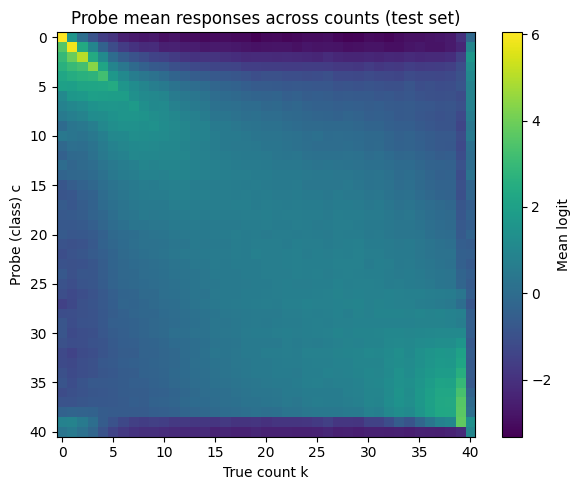

In [82]:
W = clf.coef_            # (K, d)
b = clf.intercept_       # (K,)

# logits on test set: (N_test, K)
logits = X_test @ W.T + b
K=41
# build M[c,k]: mean logit of class c over examples with true class k
M = np.zeros((K, K), dtype=np.float64)
for k_val in range(1, K+1):                 # labels are 1..K
    I = np.where(y_test == k_val)[0]
    if I.size:
        M[:, k_val-1] = logits[I].mean(axis=0)   # mean over those rows

# visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.imshow(M, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Mean logit')
plt.xlabel('True count k'); plt.ylabel('Probe (class) c')
plt.title('Probe mean responses across counts (test set)')
plt.gca().invert_yaxis()
plt.tight_layout(); plt.show()